# Precipitation analysis

This notebook is to analze and regress precipitaion data with results from ONI, CANI, and EANI.

# Imports

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import glob
from geocat.viz import util as gvutil
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.stats import t
import colormaps as cmaps

# PBSClustter

In [3]:
# Create a PBS cluster object
cluster = PBSCluster(account='P93300313',
                     job_name='ATLN-ENSO-CESMLE2',
                     cores=1,
                     memory='8GiB',
                     processes=1,
                     walltime='01:00:00',
                     queue='casper',
                     interface='ext',
                     n_workers=1)

# dont scale many workers unless using LE
# cluster.scale(10)

client = Client(cluster)
client

/glade/u/home/acruz/.conda/envs/EOFa_2025/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36349 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/acruz/proxy/36349/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/acruz/proxy/36349/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.214:40971,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/acruz/proxy/36349/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
cluster.scale(2)

In [5]:
# client.shutdown()
cluster.workers

{'PBSCluster-0': <dask_jobqueue.pbs.PBSJob: status=running>}

# Useful functions

In [6]:
def ds_map(ds_to_plt, bounds=[20, -60, 10, -10], name='figure',
           color=cmaps.precip4_diff_19lev,
           lev=np.arange(-1.5, 1.5, 0.15)):

    fig, ax = plt.subplots(1, 1,
                           subplot_kw={'projection': ccrs.PlateCarree()})
    fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
    cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
    cdat, clon = cutil.add_cyclic_point(ds_to_plt, ds_to_plt.lon)

    ax.set_title(name)
    lat_ticks = np.arange(bounds[3], bounds[2], 30)
    lon_ticks = np.arange(bounds[1], bounds[0], 60)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cf.LAND)


    def resize_colobar(event):
        plt.draw()
        posn = ax.get_position()
        cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                              0.04, posn.height])

    ax.set_extent(bounds, ccrs.PlateCarree())
    sst_contour = ax.contourf(clon, ds_to_plt.lat, cdat,
                              levels=lev,
                              # levels=40,
                              transform=ccrs.PlateCarree(), cmap=color, extend='both')
    
    fig.canvas.mpl_connect('resize_event', resize_colobar)
    ax.coastlines()
    plt.colorbar(sst_contour, cax=cbar_ax)
    resize_colobar(None)
    # plt.savefig(name, dpi=300)
    plt.show()


def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit


def xr_regression(x, y, lag_x=0, lag_y=0, dim="time", alternative="two-sided"):
    """
    From https://stackoverflow.com/questions/52108417/how-to-apply-linear-regression-to-every-pixel-in-a-large-multi-dimensional-array
    requires scipy.stats as t
    Takes two xr.Datarrays of any dimensions (input data could be a 1D
    time series, or for example, have three dimensions e.g. time, lat,
    lon), and returns covariance, correlation, coefficient of
    determination, regression slope, intercept, p-value and standard
    error, and number of valid observations (n) between the two datasets
    along their aligned first dimension.

    Datasets can be provided in any order, but note that the regression
    slope and intercept will be calculated for y with respect to x.

    Inspired by:
    https://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html

    Parameters
    ----------
    x, y : xarray DataArray
        Two xarray DataArrays with any number of dimensions, both
        sharing the same first dimension
    lag_x, lag_y : int, optional
        Optional integers giving lag values to assign to either of the
        data, with lagx shifting x, and lagy shifting y with the
        specified lag amount.
    dim : str, optional
        An optional string giving the name of the dimension on which to
        align (and optionally lag) datasets. The default is 'time'.
    alternative : string, optional
        Defines the alternative hypothesis. Default is 'two-sided'.
        The following options are available:

        * 'two-sided': slope of the regression line is nonzero
        * 'less': slope of the regression line is less than zero
        * 'greater':  slope of the regression line is greater than zero

    Returns
    -------
    regression_ds : xarray.Dataset
        A dataset comparing the two input datasets along their aligned
        dimension, containing variables including covariance, correlation,
        coefficient of determination, regression slope, intercept,
        p-value and standard error, and number of valid observations (n).

    """

    # Shift x and y data if lags are specified
    if lag_x != 0:
        # If x lags y by 1, x must be shifted 1 step backwards. But as
        # the 'zero-th' value is nonexistant, xarray assigns it as
        # invalid (nan). Hence it needs to be dropped
        x = x.shift(**{dim: -lag_x}).dropna(dim=dim)

        # Next re-align the two datasets so that y adjusts to the
        # changed coordinates of x
        x, y = xr.align(x, y)

    if lag_y != 0:
        y = y.shift(**{dim: -lag_y}).dropna(dim=dim)

    # Ensure that the data are properly aligned to each other.
    x, y = xr.align(x, y)

    # Compute data length, mean and standard deviation along dim
    n = y.notnull().sum(dim=dim)
    xmean = x.mean(dim=dim)
    ymean = y.mean(dim=dim)
    xstd = x.std(dim=dim)
    ystd = y.std(dim=dim)

    # Compute covariance, correlation and coefficient of determination
    cov = ((x - xmean) * (y - ymean)).sum(dim=dim) / (n)
    cor = cov / (xstd * ystd)
    r2 = cor**2

    # Compute regression slope and intercept
    slope = cov / (xstd**2)
    intercept = ymean - xmean * slope

    # Compute t-statistics and standard error
    tstats = cor * np.sqrt(n - 2) / np.sqrt(1 - cor**2)
    stderr = slope / tstats

    # Calculate p-values for different alternative hypotheses.
    if alternative == "two-sided":
        pval = t.sf(np.abs(tstats), n - 2) * 2
    elif alternative == "greater":
        pval = t.sf(tstats, n - 2)
    elif alternative == "less":
        pval = t.cdf(np.abs(tstats), n - 2)

    # Wrap p-values into an xr.DataArray
    pval = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    # Combine into single dataset
    regression_ds = xr.merge(
        [
            cov.rename("cov").astype(np.float32),
            cor.rename("cor").astype(np.float32),
            r2.rename("r2").astype(np.float32),
            slope.rename("slope").astype(np.float32),
            intercept.rename("intercept").astype(np.float32),
            pval.rename("pvalue").astype(np.float32),
            stderr.rename("stderr").astype(np.float32),
            n.rename("n").astype(np.int16),
        ]
    )

    return regression_ds

# Data Imports

In [7]:
files = glob.glob('/glade/campaign/collections/rda/data/d728008/gpcp_v3.2_monthly/*/*.nc4')
precip = xr.open_mfdataset(files, engine='netcdf4')
precip = precip['sat_gauge_precip']
precip.compute()

<xarray.DataArray 'sat_gauge_precip' (time: 492, lat: 360, lon: 720)> Size: 510MB
array([[[0.3376028 , 0.31622022, 0.35614043, ..., 0.35154456,
         0.40317488, 0.39641893],
        [0.33578756, 0.30677962, 0.3619819 , ..., 0.3442334 ,
         0.4184466 , 0.4141367 ],
        [0.320693  , 0.31173638, 0.372351  , ..., 0.36990678,
         0.41142496, 0.387657  ],
        ...,
        [0.10463514, 0.04420645, 0.06126066, ..., 0.3175177 ,
         0.30958372, 0.2029445 ],
        [0.09131812, 0.03955639, 0.06680226, ..., 0.31683668,
         0.30925158, 0.19534281],
        [0.09770271, 0.05784304, 0.09679842, ..., 0.31237245,
         0.29756713, 0.1884838 ]],

       [[0.39603162, 0.5406516 , 0.586973  , ..., 0.11780752,
         0.18002854, 0.31500614],
        [0.47427216, 0.64025307, 0.6513799 , ..., 0.10958626,
         0.16606998, 0.3405046 ],
        [0.44840726, 0.5706187 , 0.5835746 , ..., 0.15471238,
         0.21641284, 0.3515139 ],
...
        [0.30886766, 0.30886766, 0.30886766, ..., 0.30886766,
         0.30886766, 0.30886766],
        [0.39459535, 0.39459535, 0.39459535, ..., 0.39459535,
         0.39459535, 0.39459535],
        [0.39602637, 0.39602637, 0.39602637, ..., 0.39602637,
         0.39602637, 0.39602637]],

       [[0.29085577, 0.29085577, 0.29085577, ..., 0.29085577,
         0.29085577, 0.29085577],
        [0.30848202, 0.30848202, 0.30848202, ..., 0.30848202,
         0.30848202, 0.30848202],
        [0.31613228, 0.31613228, 0.31613228, ..., 0.31613228,
         0.31613228, 0.31613228],
        ...,
        [0.33105877, 0.33105877, 0.33105877, ..., 0.33105877,
         0.33105877, 0.33105877],
        [0.33169577, 0.33169577, 0.33169577, ..., 0.33169577,
         0.33169577, 0.33169577],
        [0.21542941, 0.21542941, 0.21542941, ..., 0.21542941,
         0.21542941, 0.21542941]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 3kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * time     (time) datetime64[ns] 4kB 1983-01-01 1983-02-01 ... 2023-12-01
Attributes:
    units:         mm/day
    long_name:     combined satellite-gauge precipitation
    valid_range:   [  0. 100.]
    cell_methods:  time: mean

# Results Import

## ONI

In [8]:
ONI = xr.open_dataset('Results/ONI.nc')
ONI

<xarray.Dataset> Size: 30kB
Dimensions:  (time: 1260)
Coordinates:
  * time     (time) datetime64[ns] 10kB 1920-01-16T12:00:00 ... 2024-12-16T12...
    month    (time) int64 10kB ...
Data variables:
    ONI      (time) float64 10kB ...

## CANI and EANI

In [9]:
AN_hadisst = xr.open_dataset('Results/CANI_EANI_HADISST.nc', engine='netcdf4')
'''
change all dt objects to strings formatted to first day of the month
then change them ack to datetime
only do in place if you dont need the original dates later
(alternative: use .copy on new object)
this can be implemented in the CANI_EANI code before export but its
here because the bugs are introduced when compared to GPCP
'''
AN_hadisst['time'] = pd.to_datetime(AN_hadisst['time'].dt.strftime('%Y-%m-01'))

CANI = AN_hadisst['CANI']
EANI = AN_hadisst['EANI']

In [10]:
AN_hadisst

<xarray.Dataset> Size: 30kB
Dimensions:  (time: 624)
Coordinates:
  * time     (time) datetime64[ns] 5kB 1970-01-01 1970-02-01 ... 2021-12-01
Data variables:
    EANI     (time) float64 5kB ...
    CANI     (time) float64 5kB ...
    PC1      (time) float64 5kB ...
    PC2      (time) float64 5kB ...
    PC3      (time) float64 5kB ...
Attributes:
    title:        Atlantic Niño Index Timeseries
    description:  Contains EANI, CANI, and PCs from EOFa done on HADISSTv1.1
    created:      2025-06-11

# select data

In [11]:
# selected dates
CANIs = CANI.sel(time=slice('1983-01-01', '2020-12-31'))
EANIs = EANI.sel(time=slice('1983-01-01', '2020-12-31'))

In [12]:
CANIs

<xarray.DataArray 'CANI' (time: 456)> Size: 4kB
[456 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 4kB 1983-01-01 1983-02-01 ... 2020-12-01
Attributes:
    description:  Central Atlantic Niño Index. PCs scaled by STD and roll mea...

# Season selection

In [13]:
# select onset for convection insight
mam_precip = precip.where(precip['time'].dt.month.isin([3, 4, 5]), drop=True).compute()
mam_CANIs = CANIs.where(CANIs['time'].dt.month.isin([3, 4, 5]), drop=True).compute()
mam_EANIs = EANIs.where(EANIs['time'].dt.month.isin([3, 4, 5]), drop=True).compute()
# select summer
jja_precip = precip.where(precip['time'].dt.month.isin([6, 7, 8]), drop=True).compute()
jja_CANIs = CANIs.where(CANIs['time'].dt.month.isin([6, 7, 8]), drop=True).compute()
jja_EANIs = EANIs.where(EANIs['time'].dt.month.isin([6, 7, 8]), drop=True).compute()
# select after peak for lasting conditions
son_precip = precip.where(precip['time'].dt.month.isin([9, 10, 11]), drop=True).compute()
son_CANIs = CANIs.where(CANIs['time'].dt.month.isin([9, 10, 11]), drop=True).compute()
son_EANIs = EANIs.where(EANIs['time'].dt.month.isin([9, 10, 11]), drop=True).compute()

# regression

select per season

In [14]:
CANIvprecip_mam = xr_regression(mam_CANIs, mam_precip).compute()
EANIvprecip_mam = xr_regression(mam_EANIs, mam_precip).compute()

CANIvprecip_jja = xr_regression(jja_CANIs, jja_precip).compute()
EANIvprecip_jja = xr_regression(jja_EANIs, jja_precip).compute()

CANIvprecip_son = xr_regression(son_CANIs, son_precip).compute()
EANIvprecip_son = xr_regression(son_EANIs, son_precip).compute()

# Plots

## CANI

### MAM

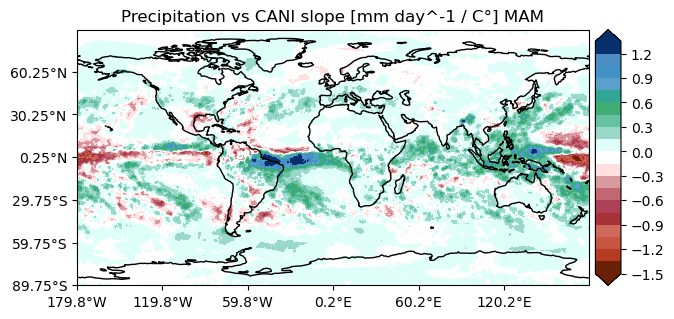

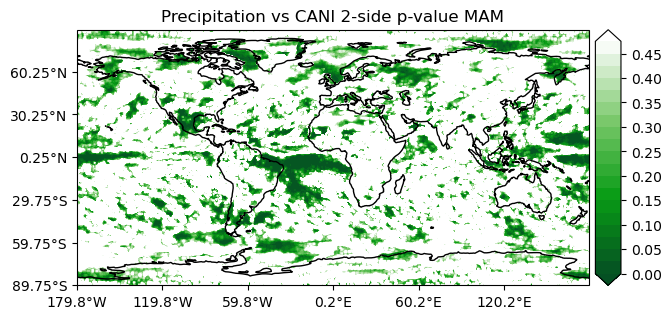

In [15]:
ds_map(CANIvprecip_mam.slope, bounds=[179.8, -179.8, 89.75, -89.75],
       name='Precipitation vs CANI slope [mm day^-1 / C°] MAM')
ds_map(CANIvprecip_mam.pvalue, bounds=[179.8, -179.8, 89.75, -89.75],
       name='Precipitation vs CANI 2-side p-value MAM', lev=np.arange(0, 0.5, 0.025),
       color=cmaps.WhiteGreen_r)

### JJA

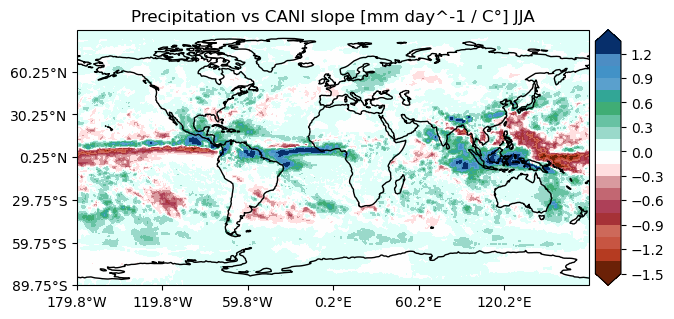

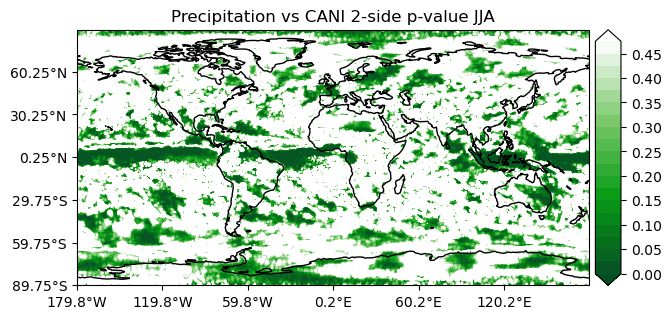

In [16]:
ds_map(CANIvprecip_jja.slope, bounds=[179.8, -179.8, 89.75, -89.75],
       name='Precipitation vs CANI slope [mm day^-1 / C°] JJA')
ds_map(CANIvprecip_jja.pvalue, bounds=[179.8, -179.8, 89.75, -89.75],
       name='Precipitation vs CANI 2-side p-value JJA', lev=np.arange(0, 0.5, 0.025),
       color=cmaps.WhiteGreen_r)

### SON

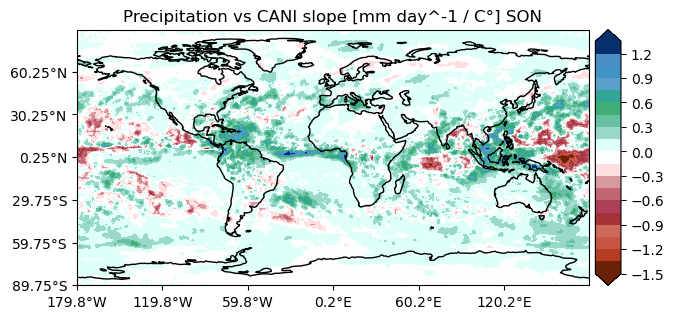

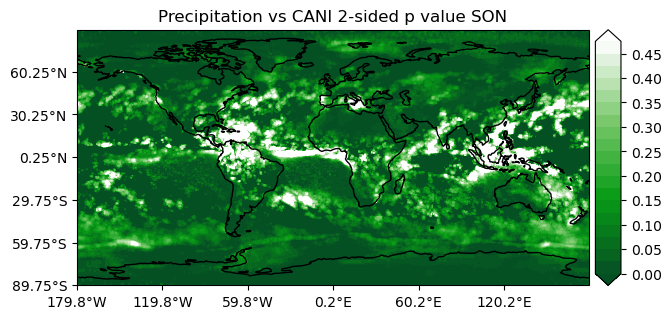

In [17]:
ds_map(CANIvprecip_son.slope, bounds=[179.8, -179.8, 89.75, -89.75],
       name='Precipitation vs CANI slope [mm day^-1 / C°] SON')
ds_map(CANIvprecip_son.slope, bounds=[179.8, -179.8, 89.75, -89.75],
       name='Precipitation vs CANI 2-sided p value SON',
       lev=np.arange(0, 0.5, 0.025),
       color=cmaps.WhiteGreen_r)

## EANI

### MAM

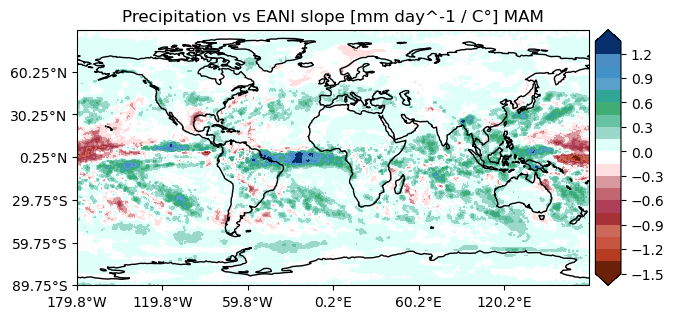

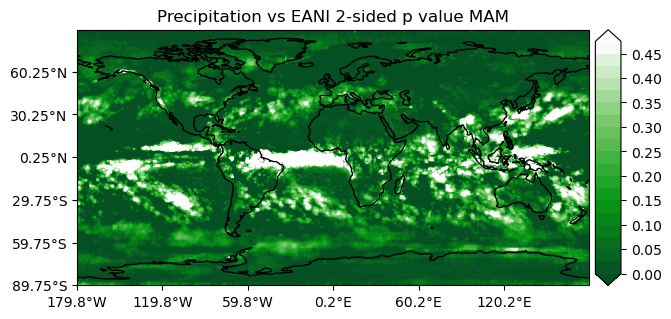

In [18]:
ds_map(EANIvprecip_mam.slope, bounds=[179.8, -179.8, 89.75, -89.75],
       name='Precipitation vs EANI slope [mm day^-1 / C°] MAM')
ds_map(EANIvprecip_mam.slope, bounds=[179.8, -179.8, 89.75, -89.75],
       name='Precipitation vs EANI 2-sided p value MAM',
       lev=np.arange(0, 0.5, 0.025),
       color=cmaps.WhiteGreen_r)

### JJA

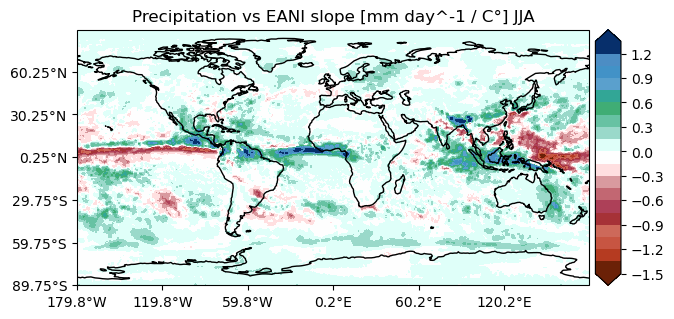

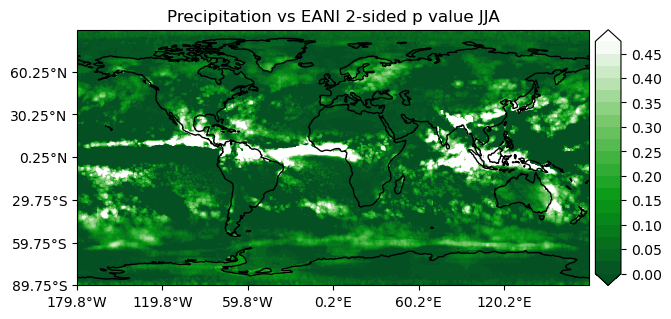

In [19]:
ds_map(EANIvprecip_jja.slope, bounds=[179.8, -179.8, 89.75, -89.75],
       name='Precipitation vs EANI slope [mm day^-1 / C°] JJA')
ds_map(EANIvprecip_jja.slope, bounds=[179.8, -179.8, 89.75, -89.75],
       name='Precipitation vs EANI 2-sided p value JJA',
       lev=np.arange(0, 0.5, 0.025),
       color=cmaps.WhiteGreen_r)

### SON

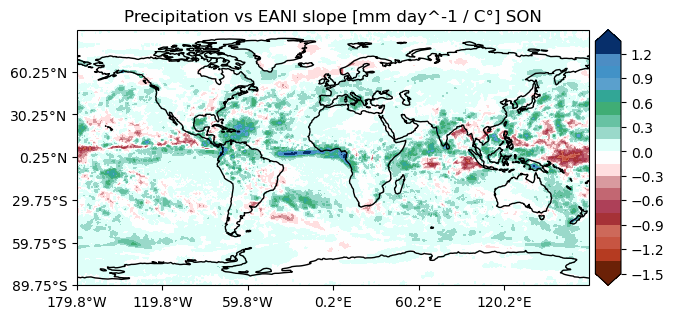

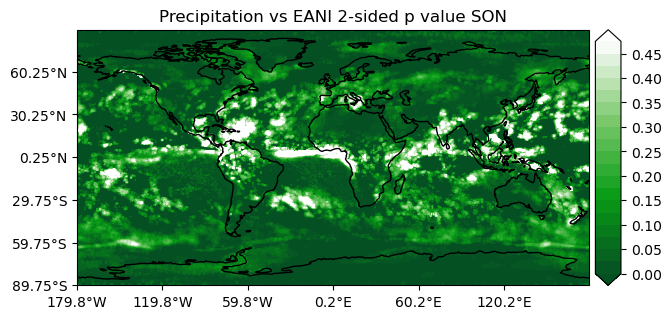

In [20]:
ds_map(EANIvprecip_son.slope, bounds=[179.8, -179.8, 89.75, -89.75],
       name='Precipitation vs EANI slope [mm day^-1 / C°] SON')
ds_map(EANIvprecip_son.slope, bounds=[179.8, -179.8, 89.75, -89.75],
       name='Precipitation vs EANI 2-sided p value SON',
       lev=np.arange(0, 0.5, 0.025),
       color=cmaps.WhiteGreen_r)